In [4]:
!pip install tensorflow

     |████████████████████████████████| 120.8 MB 1.1 MB/s eta 0:00:01    |████████▎                       | 31.1 MB 156 kB/s eta 0:09:34
     |████████████████████████████████| 1.3 MB 315 kB/s eta 0:00:01
     |████████████████████████████████| 63 kB 510 kB/s eta 0:00:01
  Using cached tensorflow_estimator-2.1.0-py2.py3-none-any.whl (448 kB)
     |████████████████████████████████| 57 kB 552 kB/s eta 0:00:011
     |████████████████████████████████| 2.6 MB 744 kB/s eta 0:00:01
Processing /Users/akshaymattoo/Library/Caches/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6/termcolor-1.1.0-cp37-none-any.whl
  Using cached absl-py-0.9.0.tar.gz (104 kB)
  Using cached gast-0.2.2.tar.gz (10 kB)
     |████████████████████████████████| 3.8 MB 800 kB/s eta 0:00:01
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
  Using cached google_auth_oauthlib-0.4.1-py2.py3-none-any.whl (18 kB)
     |████████████████████████████████| 88 kB 898 kB/s eta 0:00:01
     |███████████████

#### Build a vocabulary of the most commonly occurring words in the caption text

In [5]:
import json
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
from time import time
import collections
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

Using TensorFlow backend.


In [7]:
# Read the file tokens_clean.txt and store the cleaned captions in a dictionary
content = None

with open ("data/textFiles/tokens_clean.txt", 'r') as file:
    content = file.read()

json_acceptable_string = content.replace("'", "\"")
content = json.loads(json_acceptable_string)

In [8]:
print(type(content))

<class 'dict'>


In [9]:
# Build the vocabulary

vocab = set()
for key in content.keys():
    for sentence in content[key]:
        vocab.update(sentence.split())

print("Vocab size = %d" %len(vocab))

Vocab size = 8441


In [10]:
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)

print("Total Words = %d" %len(total_words))

Total Words = 437466


In [11]:
# Compute the frequency of occurrence of each word

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print(len(freq_cnt.keys()))

8441


In [12]:
# Sort the dictionary according to frequency of occurrence

sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

#Filter off those words which occur less than the threshold
threshold = 5
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

print(len(total_words))

2644


#### Prepare train and test data

In [13]:
# Read training and testing image names

train_file_data = ""
test_file_data = ""

with open ("data/textFiles/trainImages.txt", 'r') as file:
    train_file_data = file.read()

with open ("data/textFiles/testImages.txt", 'r') as file:
    test_file_data = file.read()

In [14]:
# Obtain a list of train and test images
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]

# Obtain image ID from image file name
train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]

In [15]:
train_data[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [16]:
# For each imageID in train_data, store its captions in a dictionary 

train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = "startseq " + caption + " endseq"
        train_content[imageID].append(cap_to_append)

In [17]:
train_content['1007320043_627395c3d8']

['startseq a child playing on a rope net  endseq',
 'startseq a little girl climbing on red roping  endseq',
 'startseq a little girl in pink climbs a rope bridge at the park  endseq',
 'startseq a small child grips onto the red ropes at the playground  endseq',
 'startseq the small child climbs on a red ropes on a playground  endseq']

### Transfer Learning

#### Extract features from Image using a ResNet50 Architecture

In [23]:
model = ResNet50(weights = 'imagenet', input_shape = (224, 224, 3))

102858752/102853048 [==============================] - 482s 5us/step


In [24]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [25]:
model_new = Model (model.input, model.layers[-2].output)

In [26]:
def preprocess_image (img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)

    # Convert 3D tensor to a 4D tendor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to ResNet50 requirement
    img = preprocess_input(img)

    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


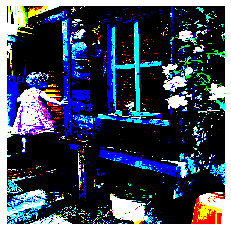

In [27]:
img = preprocess_image("data/Images/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [28]:
# A wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image (img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)

    fature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [29]:
train_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (train_data):
    image_path = "data/Images/" + imageID + ".jpg"
    
    train_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time)

Encoding in progress... STEP 0
Encoding in progress... STEP 100
Encoding in progress... STEP 200
Encoding in progress... STEP 300
Encoding in progress... STEP 400
Encoding in progress... STEP 500
Encoding in progress... STEP 600
Encoding in progress... STEP 700
Encoding in progress... STEP 800
Encoding in progress... STEP 900
Encoding in progress... STEP 1000
Encoding in progress... STEP 1100
Encoding in progress... STEP 1200
Encoding in progress... STEP 1300
Encoding in progress... STEP 1400
Encoding in progress... STEP 1500
Encoding in progress... STEP 1600
Encoding in progress... STEP 1700
Encoding in progress... STEP 1800
Encoding in progress... STEP 1900
Encoding in progress... STEP 2000
Encoding in progress... STEP 2100
Encoding in progress... STEP 2200
Encoding in progress... STEP 2300
Encoding in progress... STEP 2400
Encoding in progress... STEP 2500
Encoding in progress... STEP 2600
Encoding in progress... STEP 2700
Encoding in progress... STEP 2800
Encoding in progress... ST

In [0]:
# Store the above computed features on the disk
# Use pickle to dump the entire data

with open("encoded_train_features.pkl", "wb") as file:
    # Pickle allows to store any object as a file on the disk
    pickle.dump(train_encoding, file)

In [30]:
test_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (test_data):
    image_path = "data/Images/" + imageID + ".jpg"
    
    test_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time)

Encoding in progress... STEP 0
Encoding in progress... STEP 100
Encoding in progress... STEP 200
Encoding in progress... STEP 300
Encoding in progress... STEP 400
Encoding in progress... STEP 500
Encoding in progress... STEP 600
Encoding in progress... STEP 700
Encoding in progress... STEP 800
Encoding in progress... STEP 900
Total time taken: 208.69454503059387


In [0]:
with open("encoded_test_features.pkl", "wb") as file:
    # Pickle allows to store any object as a file on the disk
    pickle.dump(test_encoding, file)

#### Pre-process the Captions

In [31]:
# Create the word-to-index and index-to-word mappings
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [32]:
print(len(index_to_word))

2644


In [33]:
print(index_to_word[5])
print(word_to_index['is'])

is
5


In [34]:
# Add startseq and endseq also to the mappings
index_to_word[2645] = 'startseq'
word_to_index['startseq'] = 2645

index_to_word[2646] = 'endseq'
word_to_index['endseq'] = 2646

vocab_size = len(word_to_index) + 1

In [19]:
print(vocab_size)

2647


In [39]:
# Get the maximum length of a caption
max_len = 0

for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

In [40]:
print(max_len)

38


#### Create a Data Loader

In [0]:
def data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []

    n = 0
    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = encoding_train [imageID + ".jpg"]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = seq[0 : i] # The input sequence of words
                    yi = seq[i] # The next word after the above sequence (this is expected to be predicted)

                    # Add a padding of zeros ao lengths of input sequences become equal
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='0')[0] # Take the first row only, since this method inputs & returns a 2D array
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=vocab_size)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                   yield [[np.array(X1), np.array(X2)], np.array(y)]
                   X1, X2, y = [], [], []
                   n=0     

In [0]:
file = open("glove.6B.50d.txt",encoding='utf8')

In [0]:
embedding_index = {}

for line in file:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [0]:
file.close()

In [34]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [0]:
def get_embedding_matrix():
    EMBEDDING_DIM = 50
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

    for word, index in word_to_index.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

    return embedding_matrix

In [37]:
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(2647, 50)


#### Define Model Architecture

In [37]:
#Convert feature vector of image to smaller vector

#Output of ResNEt goes into following input layer 
inp_img_features = Input(shape=(2048,))
#Apply a Dropout to the input received
inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(256, activation="relu")(inp_img1)

In [41]:
#Now take Captions as input

#Actual input size will be (batch_size x max_length_of_caption)
#But here we specify only only for one example
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
# inp_cap3 captures esstenially the entire sentence that has been generated till now

ValueError: Layer dropout_3 was called with an input that isn't a symbolic tensor. Received type: <class 'keras.layers.embeddings.Embedding'>. Full input: [<keras.layers.embeddings.Embedding object at 0x640841850>]. All inputs to the layer should be tensors.